# 데이터셋 불러오기

Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 반복 가능한 객체(iterable)로 감싼다.

다음 매개변수들을 사용하여 FashionMNIST 데이터셋 을 불러옵니다:


- root 는 학습/테스트 데이터가 저장되는 경로
- train 은 학습용 또는 테스트용 데이터셋 여부를 지정
- download=True 는 root 에 데이터가 없는 경우 인터넷에서 다운로드
- transform 과 target_transform 은 특징(feature)과 정답(label) 변형(transform)을 지정

In [1]:
# 라이브러리
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [2]:
# Fashion MNIST 불러오기
training_data = datasets.FashionMNIST(
    root="data", # 저장 경로
    train=True, # 학습용 데이터셋
    download=True, # 데이터 없으면 다운로드
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # 테스트용 데이터셋
    download=True, # 데이터 없으면 다운로드
    transform=ToTensor()
)


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 데이터셋을 반복하고 시각화하기

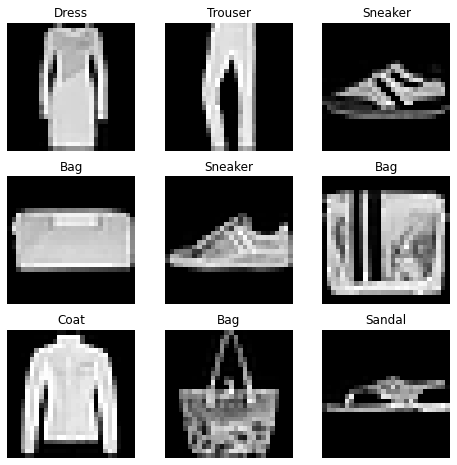

In [14]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off") # x축, y축 안보이게 설정
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현:
-  __init__, __len__, and __getitem__. 

구현을 살펴보면 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv 파일에 별도로 저장

In [15]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) # annotations_file  => 라벨 파일 경로
        self.img_dir = img_dir # 이미지 경로
        self.transform = transform # 변형 초기화
        self.target_transform = target_transform # 변형 초기화

    def __len__(self):
        return len(self.img_labels) # 데이터셋의 샘플 개수 반환

    def __getitem__(self, idx): # 주어진 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path) # 이미지를 텐서로 변환
        label = self.img_labels.iloc[idx, 1] # 정답(label)을 가져오고
        if self.transform: 
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label) 
        sample = {"image": image, "label": label} # 텐서 이미지와 라벨을 딕셔너리 형으로
        return sample

# DataLoader로 학습용 데이터 준비

Dataset 은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한다. 

모델을 학습할 때, 일반적으로 샘플들을 “미니배치(minibatch)”로 전달, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려고 함

**DataLoader 는 간단한 API로 이러한 복잡한 과정들을 추상화한 반복 가능한 객체(iteratable)**

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# DataLoader를 통해 반복하기(iterate)

DataLoader 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 반복(iterate)할 수 있다.

아래의 각 반복(iteration)은 (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는)
train_features 와 train_labels 의 묶음(batch)을 반환

shuffle=True 로 지정했으므로, 모든 배치를 반복한 뒤 데이터가 섞입니다.

(데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제어하려면 Samplers 확인)

https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


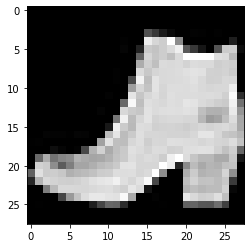

Label: 9
Label: Ankle Boot


In [29]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
print(f"Label: {labels_map[int(label)]}")